<a href="https://colab.research.google.com/github/Dhruvin3103/Yash_internship/blob/main/colab_notebooks/yash_works_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
!pip install diffusers
!pip install controlnet-aux
!pip install accelerate

# Model loading

In [ ]:
import torch
import numpy as np
from PIL import Image
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image
from controlnet_aux import OpenposeDetector

# Load pre-trained controlnet models
controlnet = [
    ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16),
]

# Initialize the pipeline
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

# Move pipeline to GPU
pipe.to("cuda")
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter-plus_sd15.bin")
pipe.set_ip_adapter_scale(0.85)

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.10/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


  0%|          | 0/100 [00:00<?, ?it/s]

# Passing inputs model, mask and garment images

  0%|          | 0/70 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=616x768 at 0x7E036E3133D0>


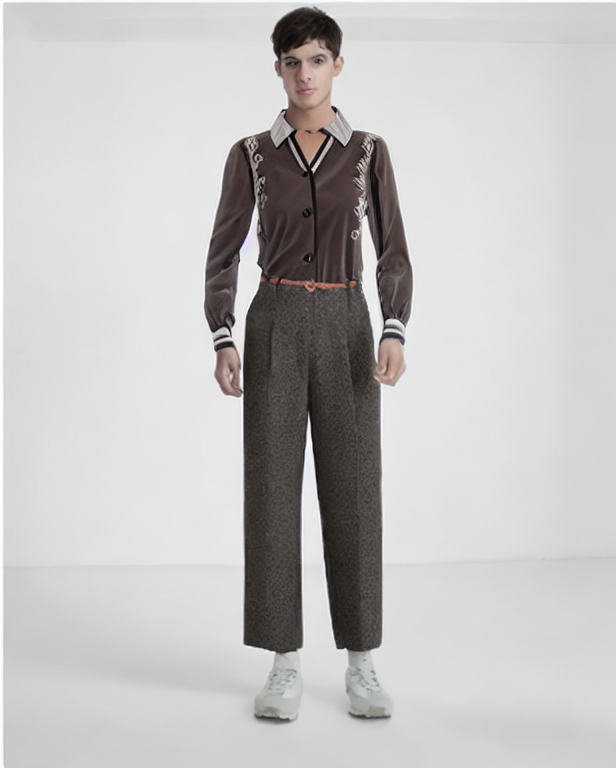

In [ ]:
garment_image = load_image("https://humanaigc-outfitanyone.hf.space/--replicas/ppht9/file=/tmp/gradio/f3ba321017355c5a0c8051d3f438e881cc87b945/top222.JPG")
mask_image = load_image("http://res.cloudinary.com/dcbnv0eyo/image/upload/v1710408624/kjioldlfxjmj4elbpdui.jpg")
init_image = load_image("https://res.cloudinary.com/dcbnv0eyo/image/upload/v1710407079/f5pls67crdnmgqu2dbhh.png") # The clothing image
prompt = "a woman wearing a dress, best quality, high quality"

# Function to calculate new image sizes
def new_sizes(image):
    original_width, original_height = image.size
    width_ratio = 768 / original_width
    height_ratio = 768 / original_height
    resize_ratio = min(width_ratio, height_ratio)
    new_width = int(original_width * resize_ratio)
    new_height = int(original_height * resize_ratio)
    closest_width = ((new_width + 7) // 8) * 8
    closest_height = ((new_height + 7) // 8) * 8
    return closest_width, closest_height


# Function to create inpaint condition
def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0
    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image


# Load and resize initial image and mask
resize_width, resize_height = new_sizes(init_image)
init_image = init_image.resize((resize_width, resize_height), Image.LANCZOS)
mask_image = mask_image.convert("L").resize((resize_width, resize_height))
inpainting_control_image = make_inpaint_condition(init_image, mask_image)


openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(init_image)
openpose_image = openpose_image.resize((resize_width, resize_height))


images = [inpainting_control_image, openpose_image]
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, disfigured"


images = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=init_image,
    mask_image=mask_image,
    ip_adapter_image=garment_image,
    control_image=images,
    controlnet_conditioning_scale=[0.5, 1.0],
    num_inference_steps=100,
    strength=0.7,
    guidance_scale=7.5,
    eta=1,
).images
for i in images:
  print(i)
  image = i
  display(i)

# Displaying all the images

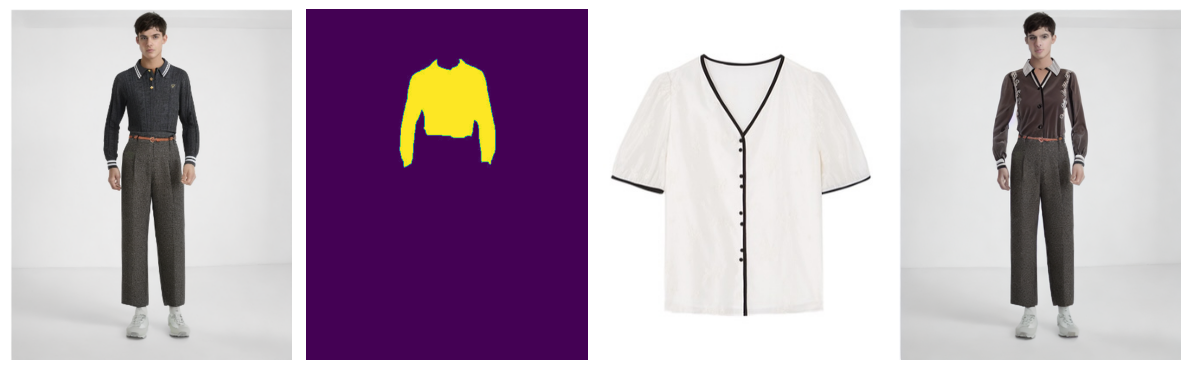

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming your images are loaded into variables
# init_image, mask_image, garment_image

# Create a figure with appropriate size for displaying 4 images horizontally
plt.figure(figsize=(12, 6))  # Adjust width and height as needed

# Display each image in a subplot, arranging them horizontally (4 columns, 1 row)
plt.subplot(1, 4, 1)  # Top-left subplot
plt.imshow(init_image)
plt.axis('off')  # Optional: Hide axes

plt.subplot(1, 4, 2)  # Second subplot
plt.imshow(mask_image)
plt.axis('off')

plt.subplot(1, 4, 3)  # Third subplot
plt.imshow(garment_image)
plt.axis('off')

plt.subplot(1, 4, 4)  # Rightmost subplot
plt.imshow(image)  # Assuming 'image' is your fourth image variable
plt.axis('off')

# Tight layout to prevent overlapping elements
plt.tight_layout()

# Display the figure
plt.show()
